In [1]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from cdft.dft3d import dft_core
from cdft.lj_eos import lj_eos
from numba import vectorize

device = torch.device('cuda')

In [2]:
sigma = 3.73
epsilon = 148.0
parameters = {'sigma':sigma, 'epsilon':epsilon}

In [3]:
structure = Structure.from_file('structures/IRMOF-1.cif')
print('formula:        ', structure.formula)
print('num_sites:      ', structure.num_sites)
print('lattice_lengths:', structure.lattice.lengths)

formula:         Zn32 H96 C192 O104
num_sites:       424
lattice_lengths: (25.832, 25.832, 25.832)


/home/lucas/miniforge3/envs/torch/lib/python3.12/site-packages/pymatgen/io/cif.py:1290: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [4]:
T = 300.0
system_size = np.array([l for l in structure.lattice.lengths])
points = np.array([64, 64, 64])
dft = dft_core(parameters, T, system_size, points, device)

In [5]:
forcefield = pd.DataFrame()
forcefield['type'] = ['Zn','H','C','O']
forcefield['sigma'] = np.array([4.045, 2.846, 3.47299, 3.033])
forcefield['epsilon'] = np.array([27.677, 7.6489, 47.8562, 48.1581])
forcefield['mass'] = np.array([65.38, 1.00784, 12.0107, 15.999])

X,Y,Z = np.meshgrid(dft.x, dft.y, dft.z, indexing='ij')

@vectorize
def lj_potential(r,sigma,epsilon):
    if r == 0:
        V = np.inf
    elif r > 12.9:
        V = 0.0
    else:
        V = 4.0*epsilon*((sigma/r)**12-(sigma/r)**6) 
    return V 

Vext = np.zeros((points[0], points[1], points[2]), dtype=np.float64)
for k, site in enumerate(structure):
    sigmasf = float(0.5*(sigma+forcefield['sigma'][forcefield['type']==site.species_string]))
    epsilonsf = float(np.sqrt(epsilon*forcefield['epsilon'][forcefield['type']==site.species_string]))
    rx = X-structure.cart_coords[k,0] 
    ry = Y-structure.cart_coords[k,1] 
    rz = Z-structure.cart_coords[k,2] 
    rx -= system_size[0]*(rx/system_size[0]).round()
    ry -= system_size[1]*(ry/system_size[1]).round()
    rz -= system_size[2]*(rz/system_size[2]).round()
    r = np.sqrt(rx**2+ry**2+rz**2)
    Vext += lj_potential(r,sigmasf,epsilonsf)

/tmp/ipykernel_5983/135069438.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmasf = float(0.5*(sigma+forcefield['sigma'][forcefield['type']==site.species_string]))
/tmp/ipykernel_5983/135069438.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  epsilonsf = float(np.sqrt(epsilon*forcefield['epsilon'][forcefield['type']==site.species_string]))
/tmp/ipykernel_5983/135069438.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmasf = float(0.5*(sigma+forcefield['sigma'][forcefield['type']==site.species_string]))
/tmp/ipykernel_5983/135069438.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) ins

Text(0, 0.5, '$y$ (\\AA{})')

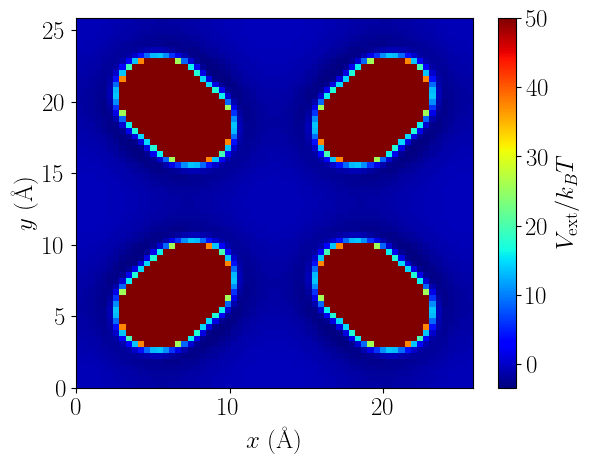

In [6]:
plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
# 'axes.linewidth':1.1, 
'lines.linewidth':1.6,
'legend.fontsize': 18,
'legend.frameon':False
#'figure.figsize':(7.9, 6.1)
})


plt.figure()
c=plt.pcolormesh(X[:,:,points[0]//2],Y[:,:,points[1]//2],Vext[:,:,points[2]//2]/T, vmax=50.0, cmap='jet')
plt.colorbar(label=r'$V_{\mathrm{ext}}/k_B T$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')

In [7]:
P = torch.hstack((torch.arange(1e5,1e6,1e5,dtype=torch.float64), torch.range(1e6,1e7,1e6,dtype=torch.float64)))
bulk_density = torch.empty_like(P)
composition = torch.tensor([1.0],dtype=torch.float64)

eos = lj_eos(parameters, T)
bulk_density[0] = eos.density(P[0],'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],bulk_density[i-1])

/tmp/ipykernel_5983/3813163443.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  P = torch.hstack((torch.arange(1e5,1e6,1e5,dtype=torch.float64), torch.range(1e6,1e7,1e6,dtype=torch.float64)))


In [8]:
dft.initial_condition(bulk_density[0],Vext)

In [9]:
Nads = torch.empty(len(P),dtype=torch.float64)
for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',
                                    solver='fire',alpha0=0.2,dt=0.1,tol=1e-6,logoutput=False)
    Nads[i] = dft.total_molecules
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Nads[i].numpy())
    if np.isnan(dft.error.numpy()): break

90 4.1699469545252766e-08 1.0 2.7669194257401486
89 6.444111828508255e-07 2.0 5.549579218874739
89 2.7664546098289203e-07 3.0000000000000004 8.34105517768275
88 5.249847269215426e-07 4.0 11.134815778396918
88 4.994245661208659e-07 5.0 13.924582315273513
90 3.4960672188292786e-07 6.000000000000001 16.70432668301583
86 4.435473192521683e-07 7.000000000000001 19.468298767738876
88 7.910594818454525e-07 8.0 22.210948497190643
86 4.953419320639329e-07 9.0 24.927051855066242
88 7.466807767957531e-07 10.0 27.611711048116362
137 9.984176031944979e-07 20.0 51.95461032747702
137 9.283800321395731e-07 30.000000000000004 70.81388958056083
129 9.927889422607015e-07 40.0 84.76412146748416
113 6.25611170075083e-07 50.00000000000001 95.13366141070883
112 8.964638445877604e-07 60.00000000000001 103.03992288786634
117 9.87852407157575e-07 70.0 109.24790855548373
116 9.797358764583035e-07 80.0 114.25702045761436
106 9.72289443732754e-07 90.00000000000001 118.3951661110631
101 9.989434155084376e-07 100.00

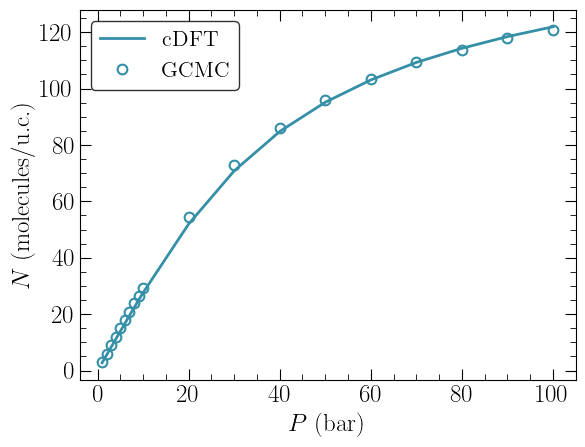

In [10]:
data = pd.read_pickle('data/isotherm_methane.pkl')

import seaborn as sns

colors = sns.color_palette("mako")

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif',  
#'figure.figsize':(7.9, 6.1)
})

plt.plot(P*1e-5, Nads, '-', color=colors[3], linewidth=2.0, label='cDFT')
plt.plot(data['pressure'], data['methane'], 'o', color=colors[3],markersize=7,markeredgewidth=1.5,mfc='none',label='GCMC')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$N$ (molecules/u.c.)', fontsize=18)
# plt.xlim([0.0,125])
# plt.ylim([None,0.004])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=8, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')
# plt.savefig('figures/isotherm_methane.pdf', bbox_inches='tight')